In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os


## making data ready

In [ ]:
import os
import shutil
import pandas as pd

def convert_to_folder_structure(root_dir, image_dir, csv_dir, data_type="train"):
  # Read the CSV file
  df = pd.read_csv(csv_dir)

  class_names = df["label"].unique()


  # create a new dataset
  if  os.path.exists(os.path.join(root_dir,"datasets")):
    print("dataset exists")
    return
  else :
    os.makedirs(os.path.join(root_dir,"datasets"))

    if data_type == "train":
      os.makedirs(os.path.join(root_dir,"datasets","train"))
    elif data_type == "test":
      os.makedirs(os.path.join(root_dir,"datasets","test"))

    # crate class folder
    for class_name in class_names:
      os.makedirs(os.path.join(root_dir,"datasets",data_type,class_name))

    # move the images to new dataset
    for index, row in df.iterrows():
      filename = row["filename"]
      label = row["label"]

      shutil.move(os.path.join(image_dir,filename), os.path.join(root_dir,"datasets",data_type,label))

root_dir="/content/drive/MyDrive/ml/butterfly-classification"
image_dir=os.path.join(root_dir,"data","train")
csv_dir=os.path.join(root_dir,"data","Training_set.csv")
convert_to_folder_structure(root_dir=root_dir, image_dir=image_dir,csv_dir=csv_dir)

dataset exists


In [ ]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms

# class CustomImageDataset(Dataset):
#     def __init__(self, csv_file, root_dir, transform=None):
#         self.labels_df = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform
#         self.class_names = self.labels_df['label'].unique()

#     def __len__(self):
#         return len(self.labels_df)

#     def __getitem__(self, idx):

#         # this right here gets the  name of the image
#         img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
#         image = Image.open(img_name).convert('RGB')

#         # this right here gets the label of the respective image
#         label = self.labels_df.iloc[idx, 1]

#         if self.transform:
#             image = self.transform(image)

#         return (image,label)


# # Paths
# dataset_path = '/content/drive/MyDrive/ml/butterfly-classification/data'
# train_csv = os.path.join(dataset_path, 'Training_set.csv')
# test_csv = os.path.join(dataset_path, 'Testing_set.csv')
# train_dir = os.path.join(dataset_path, 'train')
# test_dir = os.path.join(dataset_path, 'test')

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

In [ ]:
# Datasets

# dataset = CustomImageDataset(csv_file=train_csv, root_dir=train_dir, transform=transform)
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/ml/butterfly-classification/datasets/train", transform=transform)

In [ ]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [ ]:
len(train_dataset), len(test_dataset)

(5200, 1299)

In [ ]:
class_names = dataset.classes

In [ ]:
# creating data batches
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())


In [ ]:
len(train_dataloader)

163

## creating model

In [ ]:
# creating device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# freezing the layers
for param in model.features.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
                    nn.Dropout(p=0.2, inplace=True),
                    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)


In [ ]:
# creating loss and optimizer function

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
def train_model(model,dataloader,optimizer,loss_fn,accuracy_fn):
  train_loss, train_accuracy = 0,0

  for batch, (X,y) in enumerate(dataloader):
    model.train()
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y)
    accuracy = accuracy_fn(y_true=y, y_pred=y_pred)



    if batch % 100 == 0:
      print(f"Loss: {loss}, Accuracy: {accuracy}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return {"loss":train_loss/len(dataloader),
          "accuracy":train_accuracy/len(dataloader)
          }

In [ ]:
def test_model(model,dataloader,loss_fn,accuracy_fn):
  test_loss, test_accuracy = 0,0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y)
    accuracy = accuracy_fn(y_true=y, y_pred=y_pred)

    test_loss += loss
    test_accuracy += accuracy

    if batch % 100 == 0:
      print(f"Loss: {loss}, Accuracy: {accuracy}")

  return {"loss":test_loss/len(dataloader),
          "accuracy":accuracy/len(dataloader)
          }


In [ ]:
from tqdm.auto import tqdm

def train(model,train_dataloader,loss_fn,optimizer,accuracy_fn,epochs):

  results = {
      'train_loss':[],
      'train_accuracy':[],
      'test_loss':[],
      'test_accuracy':[]
  }

  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}")


    train_result = train_model(model=model,dataloader=train_dataloader,optimizer=optimizer,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
    test_result = test_model(model=model, dataloader=test_dataloader, loss_fn=loss_fn,accuracy_fn=accuracy_fn)

    train_loss, train_accuracy = train_result['loss'], train_result['accuracy']
    test_loss, test_accuracy = test_result['loss'], test_result['accuracy']

    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_accuracy)
    results['test_loss'].append(test_loss)
    results['test_accuracy'].append(test_accuracy)

    print(f" Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


  return results

In [ ]:
epochs=10
results = train(model,train_dataloader,loss_fn,optimizer,accuracy_fn,epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loss: 4.332732677459717, Accuracy: 3.125
Loss: 2.054391622543335, Accuracy: 65.625
Loss: 1.6596890687942505, Accuracy: 75.0
 Train Loss: 0.0, Train Accuracy: 0.0, Test Loss: 1.591848611831665, Test Accuracy: 2.1822849807445444
Epoch: 2
Loss: 1.354638934135437, Accuracy: 90.625
Loss: 1.2209335565567017, Accuracy: 78.125
Loss: 1.1183900833129883, Accuracy: 81.25
 Train Loss: 0.0, Train Accuracy: 0.0, Test Loss: 1.0922387838363647, Test Accuracy: 2.310654685494223
Epoch: 3
Loss: 0.6934072971343994, Accuracy: 93.75
Loss: 0.688983678817749, Accuracy: 87.5
Loss: 0.9716346859931946, Accuracy: 90.625
 Train Loss: 0.0, Train Accuracy: 0.0, Test Loss: 0.901058554649353, Test Accuracy: 2.310654685494223
Epoch: 4
Loss: 0.7123582363128662, Accuracy: 87.5
Loss: 0.4211438298225403, Accuracy: 96.875
Loss: 0.8918848037719727, Accuracy: 84.375
 Train Loss: 0.0, Train Accuracy: 0.0, Test Loss: 0.7886082530021667, Test Accuracy: 2.310654685494223
Epoch: 5
Loss: 0.32758408784866333, Accuracy: 96.8

In [ ]:
torch.save(model,"/content/drive/MyDrive/ml/butterfly-classification/models/pytorch_model.pt")

In [ ]:
model = torch.load("/content/drive/MyDrive/ml/butterfly-classification/models/pytorch_model.pt")

In [ ]:
def eval_model(model, dataloader):
  model.eval()
  with torch.inference_mode():
    y_preds = []
    y_true = []

    for X,y in dataloader:
      y_logits = model(X)
      y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      y_preds.append(y_pred.cpu())
      y_true.append(y)

    return torch.cat(y_preds)

In [ ]:
y_preds = eval_model(model,test_dataloader)

In [ ]:
y_true = torch.tensor([label for _,label in test_dataset])

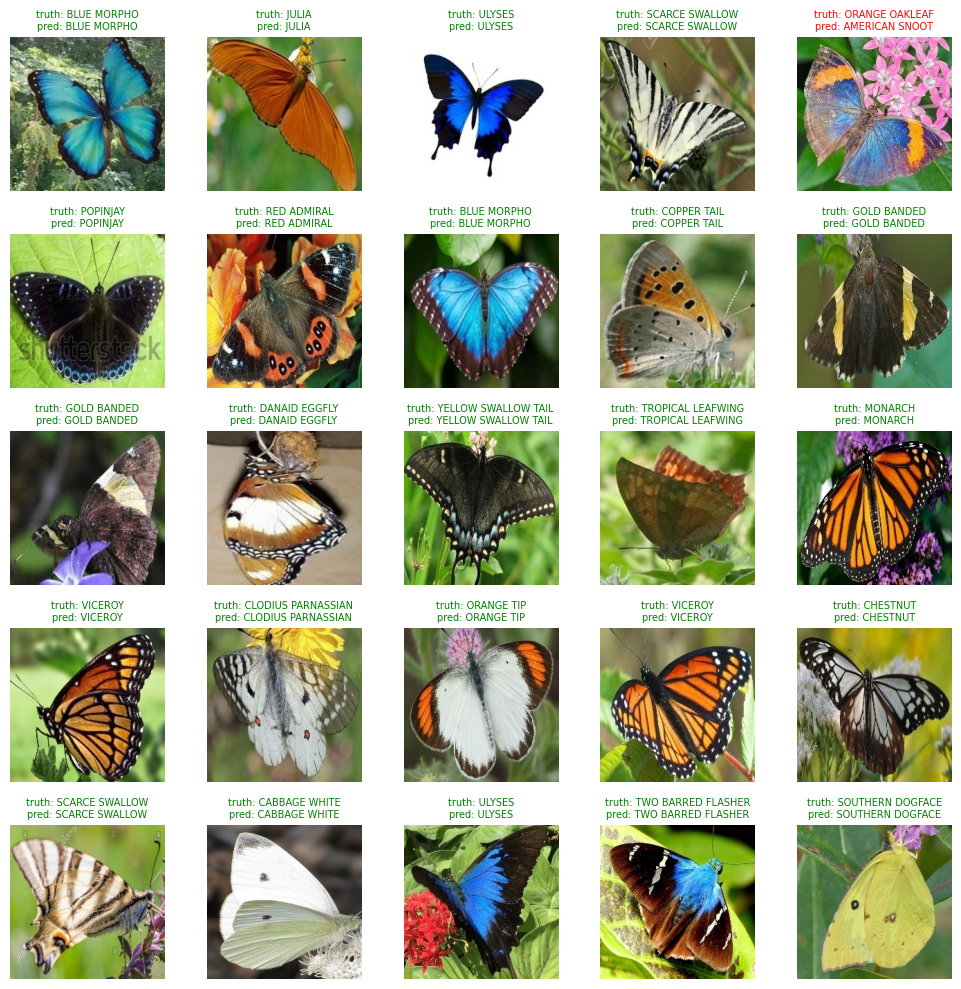

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random


simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def pred_and_plot(model, data_dir):
    model.eval()
    with torch.inference_mode():
        plt.figure(figsize=(10, 10))

        for i in range(25):
            # Randomly select a class folder and an image
            class_folder = random.choice(os.listdir(data_dir))
            class_path = os.path.join(data_dir, class_folder)
            image_name = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, image_name)

            # Load the image
            img = Image.open(image_path)
            label = class_names.index(class_folder)

            # Transform the image
            transformed_image = transform(img)
            simple_transformed_image = simple_transform(img)

            # Perform prediction
            y_logits = model(transformed_image.unsqueeze(dim=0).to(device))
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            y_label = class_names[y_pred]
            y_true = class_names[label]

            # Plot the image
            plt.subplot(5, 5, i + 1)
            color = "green" if y_label == y_true else "red"
            plt.imshow(simple_transformed_image.permute(1, 2, 0))
            plt.title(f"truth: {y_true}\npred: {y_label}", color=color, fontsize=7)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Call the function with the model and directory path
data_dir = "/content/drive/MyDrive/ml/butterfly-classification/datasets/train"
pred_and_plot(model, data_dir)


In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics

from torchmetrics.classification import MulticlassConfusionMatrix

confusion_matrix = MulticlassConfusionMatrix(num_classes=len(class_names))
matrix = confusion_matrix(y_preds, y_true)

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

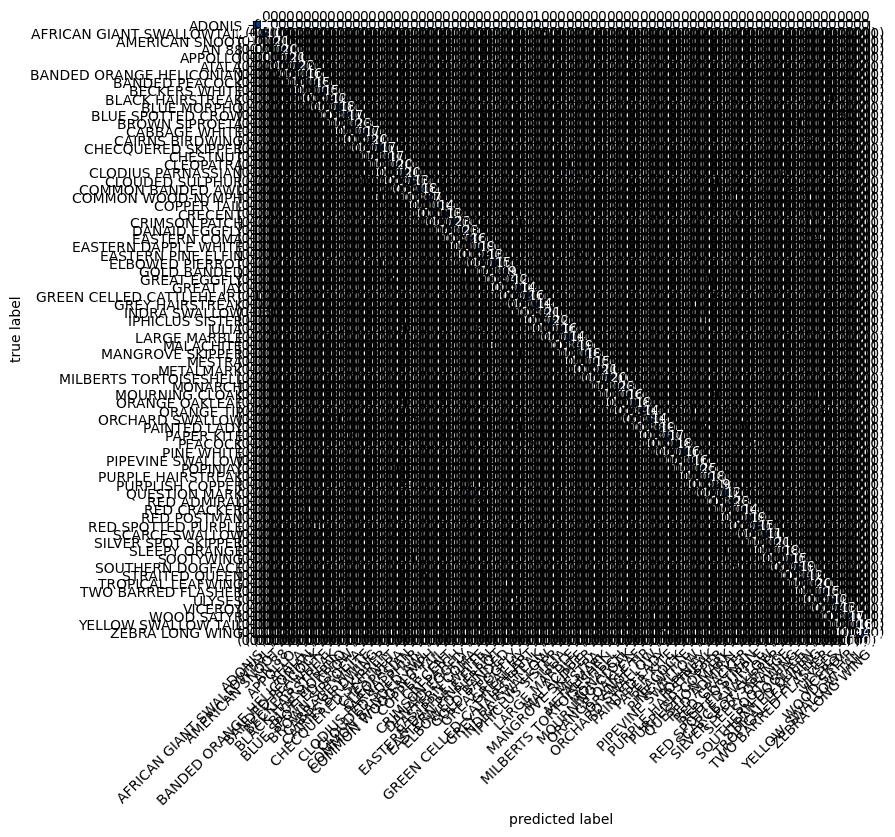

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=matrix.numpy(),
                      figsize=(12,8),
                      class_names=class_names,
                      show_normed=True)